In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import keras.datasets.mnist as mnist

In [3]:
(train_image, train_label), (test_image, test_label) = mnist.load_data() 

In [13]:
# 测试：
train_label = train_label.reshape(60000,1); test_lable = test_label.reshape(10000,1)
train_image.shape, train_label.shape, test_image.shape, test_label.shape

((60000, 28, 28), (60000, 1), (10000, 28, 28), (10000,))

(<matplotlib.image.AxesImage at 0x1f2b188ee88>, array([5], dtype=uint8))

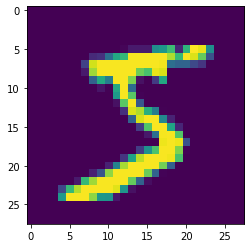

In [14]:
plt.imshow(train_image[0]), train_label[0]

# 多层网络搭建

In [15]:
model = keras.Sequential()

In [16]:
from keras import layers

In [17]:
# 因为现在是60000个二维数组，而Dense全连接层要求的数据总体是二维的，因此首先要把每个二维数组“展平”！
# 28 x 28 = 784 —— 展平后相当于看成“784”个特征x即可（不展平，用二维数组其实也是这么多特征） 

# keras中展平操作，把它也当作了一层！很方便！
# 展平层不需要多余的操作，它展完后也相当于一层，只不过这一层没有需要训练的参数。 —— 必须是训完完毕后才能查看model.summary()

model.add( layers.Flatten() )  # (60000, 28, 28) —— (60000, 784)
model.add( layers.Dense(64, activation = 'relu') )
model.add( layers.Dense(10, activation = 'softmax') )

In [18]:
model.compile( optimizer = 'adam',
               loss = 'sparse_categorical_crossentropy',
               metrics = ['acc']
)

In [19]:
# 当训练数据很大时，不宜一次性把所有数据都放入，否则内存很可能会溢出！
# 所以在每一轮训练中，再细分为多个批次；例如本例中60000个训练数据，再一轮训练中就要再分 77 次训练完！

# 说明：理论上一次性把所有训练集一起放入效果最好！这样会很有效学习图片/数据间的共性！避免把某些图的特性当关键信息学习了。
#       但训练样本太多、特征数x太多时，一次性放入会很占内存；
#       因此，batch_size每批次放入的数据量“不能太小”！
history = model.fit( train_image, train_label, epochs = 5, batch_size = 512, validation_data=(test_image, test_label) )

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 12us/step - loss: 17.6744 - acc: 0.7346 - val_loss: 3.4199 - val_acc: 0.8456
Epoch 2/5
60000/60000 [==============================] - 1s 10us/step - loss: 2.4568 - acc: 0.8498 - val_loss: 1.6864 - val_acc: 0.8397
Epoch 3/5
60000/60000 [==============================] - 1s 10us/step - loss: 1.3076 - acc: 0.8434 - val_loss: 1.0778 - val_acc: 0.8440
Epoch 4/5
60000/60000 [==============================] - 1s 10us/step - loss: 0.8762 - acc: 0.8581 - val_loss: 0.8347 - val_acc: 0.8543
Epoch 5/5
60000/60000 [==============================] - 1s 10us/step - loss: 0.6689 - acc: 0.8760 - val_loss: 0.7332 - val_acc: 0.8771


In [11]:
type(history)

keras.callbacks.callbacks.History

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.evaluate(train_image, train_label)

60000/60000 [==============================] - 1s 17us/step


[0.03537158152853826, 0.9889333248138428]

In [23]:
model.evaluate(test_image, test_label)

10000/10000 [==============================] - 0s 20us/step


[0.4573480314676113, 0.9564999938011169]

In [24]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

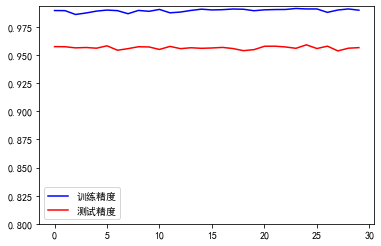

In [26]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False    # 步骤二（解决坐标轴负数的负号显示问题）
# 训练精度与测试精度的对比图：
plt.plot( history.epoch, history.history.get('acc'), c = 'b', label = '训练精度' )
plt.plot( history.epoch, history.history.get('val_acc'), c = 'r', label = '测试精度' )
plt.ylim( ymin=0.8 )
plt.legend()

虽然看上去精度都很高，但其实很明显有点“过拟合”存在：二者精度之间有差距，且没有缩小差距的趋势！所以我们要用“总原则”来调整网络：
- 先进一步提高模型对训练数据的拟合能力，即提高模型预测的“上限”！—— 过拟合效果进一步加大；
- 再使用dropout、正则化等策略降低过拟合；
- 然后再进一步增大网络容量，重复多次上述操作。

注意：每一次使用dropout后，由于每次训练网络都有很大单元死掉，因此总训练轮次epochs要比原始网络多！